<h1 style="text-align:center;">Integrate experimental Ala-scan / X-scan data with AF3 models</h1>

In [101]:
import glob
import os
import pandas as pd
import pickle
import numpy as np

from anarci import anarci
from Bio.PDB import PDBParser, NeighborSearch, PDBIO, Superimposer, MMCIFParser
from Bio.SeqUtils import seq1

import matplotlib.pyplot as plt
import seaborn as sns

from Bio.PDB import MMCIFParser, DSSP
from Bio.PDB.SASA import ShrakeRupley

# Infer TCR sequence

In [28]:
# Construct lookup table
anno_dir = '/Users/roessner/Documents/PostDoc/Data/MixTCRviz/data_raw/HomoSapiens' # full sequences for VJ-segments
ref_csvs = glob.glob(f'{anno_dir}/*.csv')
ref_csvs.sort()

ref_tables = {}

for file in ref_csvs:
    name = os.path.basename(file).replace('.csv', '')  # e.g. TRAV
    df = pd.read_csv(file)
    df['full_clean'] = df['full'].str.replace(r'[-*]', '', regex=True)
    ref_tables[name] = df

lookup = {}

for gene_type, df in ref_tables.items():
    df = df.set_index('Unnamed: 0')
    
    lookup[gene_type] = {
        'full': df['full_clean'].to_dict(),
        'cdr3': df['CDR3'].to_dict()
    }

def reconstruct_chain(v_gene, j_gene, observed_cdr3, v_type, j_type):
    v_full = lookup[v_type]['full'][v_gene]
    v_ref_cdr3 = lookup[v_type]['cdr3'][v_gene]

    j_full = lookup[j_type]['full'][j_gene]
    j_ref_cdr3 = lookup[j_type]['cdr3'][j_gene]

    v_clean = v_full[:-len(v_ref_cdr3)]
    j_clean = j_full[len(j_ref_cdr3):]
    
    return v_clean + observed_cdr3 + j_clean

In [91]:
topdir = '../260202_YF-modes/data_julien'
batches = ['LAU5013/YF_LAU5013_sc_WT', 'Public_Data/YF_public_pairedData_20251010']

threshold = 0.5

lst=[]
for batch in batches:
    batch_short = batch.split('/')[0]
    csv_file = glob.glob(f'{topdir}/{batch}/*.csv')[0]
    df = pd.read_csv(csv_file)
    df = df[(df["TEMPOproblem"].isna()) & (df['AF3_iptm_pair_mean'] > threshold)]
    df['batch'] = batch_short
    lst.append(df)

df = pd.concat(lst)
df = df[['id', 'batch', 'cdr1_TRA', 'cdr2_TRA', 'cdr3_TRA', 'cdr1_TRB', 'cdr2_TRB', 'cdr3_TRB', 'TRAV', 'TRAJ', 'TRBV', 'TRBJ']]

# annotate cluster
df_clusters = pd.read_csv('../260202_YF-modes/pca_CDR1A_cluster.csv')[['PDB', 'batch','cluster']]
df_clusters = df_clusters.rename(columns={'PDB':'id'})
df = pd.merge(df, df_clusters, on=['id', 'batch'])

# infer full TCR sequence
df['TRA_full'] = df.apply(
    lambda row: reconstruct_chain(
        row['TRAV'], row['TRAJ'], row['cdr3_TRA'],
        'TRAV', 'TRAJ'
    ),
    axis=1
)

df['TRB_full'] = df.apply(
    lambda row: reconstruct_chain(
        row['TRBV'], row['TRBJ'], row['cdr3_TRB'],
        'TRBV', 'TRBJ'
    ),
    axis=1
)

df.to_csv('AF_models_high_conf.csv', index=False)


# Align CDR loops based on IMGT numbering

In [235]:
def imgt_number_sequence(seq, chain_type="A"):
    """
    Number a full TCR chain sequence using IMGT via ANARCI.
    chain_type: 'A' = alpha, 'B' = beta
    Returns a dictionary: IMGT_position -> amino acid
    """
    results = anarci(
        sequences=[("query", seq)],
        scheme="imgt",
        assign_germline=True)  # for alpha
    
    numbering = results[0][0][0][0]  # list of ((pos, ins), aa)

    imgt_map = {}

    for ((pos, ins), aa) in numbering:
        if aa != "-":
            key = f"{pos}{ins.strip()}" if ins.strip() else str(pos)
            imgt_map[key] = aa

    return imgt_map


def extract_cdr_positions(imgt_map, start, end):
    """
    Extract residues within a CDR range.
    Handles insertions like 111A, 111B
    """
    cdr_positions = {}
    for key, aa in imgt_map.items():
        numeric = int(''.join(filter(str.isdigit, key)))
        if start <= numeric <= end:
            cdr_positions[key] = aa
    return cdr_positions

In [236]:
# cdr loops according to imgt convention
cdr1_alpha = (27, 38)
cdr2_alpha = (56, 65)
cdr3_alpha = (104, 118)

cdr1_beta = (27, 38)
cdr2_beta = (56, 65)
cdr3_beta = (104, 118)

df = pd.read_csv('AF_models_high_conf.csv')

cdr_results = {}

for _, row in df.iterrows():
    tcr_id = f'{row['id']}.{row['batch']}'
    # Alpha chain
    alpha_map = imgt_number_sequence(row['TRA_full'], chain_type='A')
    cdr1_alpha_map = extract_cdr_positions(alpha_map, *cdr1_alpha)
    cdr2_alpha_map = extract_cdr_positions(alpha_map, *cdr2_alpha)
    cdr3_alpha_map = extract_cdr_positions(alpha_map, *cdr3_alpha)

    # Beta chain
    beta_map = imgt_number_sequence(row['TRB_full'], chain_type='B')
    cdr1_beta_map = extract_cdr_positions(beta_map, *cdr1_beta)
    cdr2_beta_map = extract_cdr_positions(beta_map, *cdr2_beta)
    cdr3_beta_map = extract_cdr_positions(beta_map, *cdr3_beta)

    # correct anarci mistakes
    if row['TRAV'] == 'TRAV12-1':
        cdr2_alpha_map = {'56': 'V', '57': 'Y', '58': 'S', '63': 'S', '64': 'G', '65': 'N'}
    elif row['TRAV'] == 'TRAV40':
        cdr2_alpha_map = {'56': 'E', '57': 'T', '64': 'M', '65': 'E'}

    # Store
    cdr_results[tcr_id] = {
        "cdr1_TRA": cdr1_alpha_map,
        "cdr2_TRA": cdr2_alpha_map,
        "cdr3_TRA": cdr3_alpha_map,
        "cdr1_TRB": cdr1_beta_map,
        "cdr2_TRB": cdr2_beta_map,
        "cdr3_TRB": cdr3_beta_map,
    }

# build aligned dataframe
all_positions = set()
for tcr_id, cdr_dict in cdr_results.items():
    for cdr_name, cdr_map in cdr_dict.items():
        all_positions.update([(cdr_name, pos) for pos in cdr_map.keys()])

# Sort positions numerically + insertion letters
def imgt_sort_key(x):
    cdr_name, pos = x
    num = int(''.join(filter(str.isdigit, pos)))
    ins = ''.join(filter(str.isalpha, pos))
    return (cdr_name, num, ins)

all_positions = sorted(all_positions, key=imgt_sort_key)

# Create final dataframe
final_df = pd.DataFrame(index=cdr_results.keys(), columns=pd.MultiIndex.from_tuples(all_positions))

for tcr_id, cdr_dict in cdr_results.items():
    for cdr_name, cdr_map in cdr_dict.items():
        for pos, aa in cdr_map.items():
            final_df.loc[tcr_id, (cdr_name, pos)] = aa

final_df.to_csv('cdr_imgt_aligned.csv')
final_df


cdr1_TRA                       cdr1_TRB        ...  \
                          27 28 29   30   36 37 38       27 28 29  ...   
tcr0001.LAU5013            D  R  G  NaN    S  Q  S        L  G  H  ...   
tcr0005.LAU5013            D  R  G  NaN    S  Q  S        M  N  H  ...   
tcr0008.LAU5013            D  R  G  NaN    S  Q  S        D  F  Q  ...   
tcr0010.LAU5013            N  S  A  NaN    S  Q  S        L  G  H  ...   
tcr0014.LAU5013            D  R  G  NaN    S  Q  S        S  G  D  ...   
...                      ... .. ..  ...  ... .. ..      ... .. ..  ...   
tcr0384.Public_Data        T  S  I  NaN  NaN  N  N        S  G  D  ...   
tcr0385.Public_Data        D  R  G  NaN    S  Q  S        S  G  H  ...   
tcr0386.Public_Data        S  V  F  NaN  NaN  S  S        S  G  H  ...   
tcr0387.Public_Data        D  R  G  NaN    S  Q  S        L  N  H  ...   
tcr0388.Public_Data        D  R  G  NaN    S  Q  S        M  N  H  ...   

                    cdr3_TRB                                         
                         112 112A 112B 112C 113 114 115 116 117 118  
tcr0001.LAU5013            G    G    G  NaN   A   D   T   Q   Y   F  
tcr0005.LAU5013            G  NaN  NaN  NaN   A   Y   E   Q   Y   F  
tcr0008.LAU5013            G  NaN  NaN  NaN   T   D   T   Q   Y   F  
tcr0010.LAU5013            G    G  NaN  NaN   A   Y   E   Q   Y   F  
tcr0014.LAU5013            G  NaN  NaN  NaN   S   Y   E   Q   Y   F  
...                      ...  ...  ...  ...  ..  ..  ..  ..  ..  ..  
tcr0384.Public_Data        F  NaN  NaN  NaN   Y   N   E   Q   F   F  
tcr0385.Public_Data        P    G  NaN  NaN   A   G   E   L   F   F  
tcr0386.Public_Data        Q    G  NaN  NaN   Y   N   G   Y   T   F  
tcr0387.Public_Data        G  NaN  NaN  NaN   A   Y   E   Q   Y   F  
tcr0388.Public_Data        I  NaN  NaN  NaN   A   Y   E   Q   Y   F  

[720 rows x 67 columns]

# Infer structure-based residue index

In [5]:
def extract_cdr_resids(pdb_path, cdr_dict, chain_map={"TRA":"A","TRB":"B"}):
    """
    Extract residue id of CDRs based on the respective sequences.
    """
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("pdb", pdb_path)
    
    cdr_resids = {}
    for cdr_name, cdr_seq in cdr_dict.items():
        # get tcr chain
        chain_id = chain_map[cdr_name.split('_')[-1]]
        chain_obj = structure[0][chain_id]

        # Get all residues with C-alpha
        residues = [res for res in chain_obj if res.id[0] == " " and "CA" in res]

        # Convert 3-letter PDB codes to 1-letter
        seq = "".join([seq1(res.get_resname()) for res in residues])
 
        # find CDR sequence in the chain sequence
        L = len(cdr_seq)
        start_idx = seq.find(cdr_seq)
        if start_idx == -1:
            print(f"Warning: CDR {cdr_name} sequence not found in chain {chain_id} of {pdb_path}")
            return None
        
        end_idx = start_idx + L
        
        # extract cdr resids
        resids = np.array([res.get_id()[1] for res in residues[start_idx:end_idx]])
        cdr_resids[cdr_name] = resids

    return cdr_resids

from Bio.PDB import PDBParser, NeighborSearch
import numpy as np

def compute_cdr_min_distances(pdb_file, cdr_resids, chain_map, pmhc_chains=("A","E")):
    """
    Extract minimal distances between CDR residues and pMHC.
    """
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("tcr", pdb_file)
    
    # Collect all atoms of pMHC chains
    pmhc_atoms = []
    for chain_id in pmhc_chains:
        chain = structure[0][chain_id]
        pmhc_atoms.extend([atom for atom in chain.get_atoms() if atom.element != "H"])
    ns = NeighborSearch(pmhc_atoms)
    
    cdr_distances = {}
    
    for cdr, res_nums in cdr_resids.items():
        # figure out which TCR chain this cdr belongs to
        if "TRA" in cdr:
            tcr_chain_id = chain_map["TRA"]
        else:
            tcr_chain_id = chain_map["TRB"]
        
        chain = structure[0][tcr_chain_id]
        distances = []
        
        for res_num in res_nums:
            try:
                res = chain[(' ', res_num, ' ')]  # ('HETATM flag', resid, insertion)
            except KeyError:
                distances.append(np.nan)
                continue
            
            # get all heavy atoms
            res_atoms = [atom for atom in res.get_atoms() if atom.element != "H"]
            
            # compute min distance of this residue to pMHC atoms
            if res_atoms:
                min_dist = min(atom - pmhc_atom for atom in res_atoms for pmhc_atom in pmhc_atoms)
                distances.append(min_dist)
            else:
                distances.append(np.nan)
        
        cdr_distances[cdr] = np.array(distances)
    
    return cdr_distances


def replace_residues_with_distances(df_aligned, cdr_min_distances, tcr_index):
    """
    Annotate aligned cdr loops with minimal distance values.
    """
    
    for cdr in cdr_min_distances:
        if cdr not in df_aligned.columns.levels[0]:
            continue
        
        # All IMGT positions for this CDR
        cdr_cols = df_aligned[cdr].columns
        
        # Row slice for this CDR
        row_vals = df_aligned.loc[tcr_index, (cdr, slice(None))]
        
        # Count non-NaN positions in the alignment
        n_non_nan = row_vals.notna().sum()
        
        # Number of distances
        n_distances = len(cdr_min_distances[cdr])

        if n_distances != n_non_nan:
            raise ValueError(
                f"Mismatch for {tcr_index} {cdr}: "
                f"{n_non_nan} non-NaN positions in alignment, "
                f"but {n_distances} distances provided"
            )

        # Replace only non-NaN letters with distances
        new_row = row_vals.copy()
        distance_idx = 0

        for col in cdr_cols:
            if pd.isna(row_vals[cdr][col]):
                continue  # keep NaN
            new_row[cdr][col] = cdr_min_distances[cdr][distance_idx]
            distance_idx += 1

        # Assign back
        df_aligned.loc[tcr_index, (cdr, slice(None))] = new_row
        
    return df_aligned

    

In [241]:
topdir = '../260202_YF-modes/data_julien'
batches = {'LAU5013': 'LAU5013/YF_LAU5013_sc_WT', 
           'Public_Data':'Public_Data/YF_public_pairedData_20251010'}

df = pd.read_csv('AF_models_high_conf.csv')

df_aligned = pd.read_csv('cdr_imgt_aligned.csv', header=[0,1], index_col=0)

for idx, row in df.iterrows():
    tcr_id = row['id']
    batch_short = row['batch']

    pdb_file = f'{topdir}/{batches[batch_short]}/model_pdb_align_exp/{tcr_id}.pdb'
    chain_map={"TRA":"B","TRB":"C"}

    # get residue ids
    cdr_dict = {cdr: str(row[cdr]).upper() for cdr in ["cdr1_TRA","cdr2_TRA","cdr3_TRA","cdr1_TRB","cdr2_TRB","cdr3_TRB"]}
    cdr_resids = extract_cdr_resids(pdb_file, cdr_dict, chain_map)

    # get pMHC distance
    cdr_min_distances = compute_cdr_min_distances(pdb_file, cdr_resids, chain_map)

    # get aligned dataframe
    df_aligned = replace_residues_with_distances(df_aligned, cdr_min_distances, f'{tcr_id}.{batch_short}')

df_aligned.to_csv('cdr_imgt_aligned_min_dist.csv')
    

/var/folders/2v/m8p5rbh538sgyrgvrcyb210h0000gn/T/ipykernel_56058/905012013.py:121: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  new_row[cdr][col] = cdr_min_distances[cdr][distance_idx]
/var/folders/2v/m8p5rbh538sgyrgvrcyb210h0000gn/T/ipyker

# Visualization

/var/folders/2v/m8p5rbh538sgyrgvrcyb210h0000gn/T/ipykernel_56058/2496543265.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 1 if x < 5 else 0)


                    cdr1_TRA                cdr1_TRB           ... cdr3_TRB  \
                          27 28 29 36 37 38       27 28 29 36  ...      110   
tcr0001.LAU5013            0  1  1  1  1  1        0  0  0  0  ...        0   
tcr0005.LAU5013            0  1  1  0  1  1        0  0  0  0  ...        1   
tcr0008.LAU5013            0  1  1  1  1  1        0  0  0  0  ...        1   
tcr0010.LAU5013            0  1  1  1  1  1        0  0  0  0  ...        1   
tcr0014.LAU5013            0  1  1  1  1  1        0  0  0  0  ...        1   
...                      ... .. .. .. .. ..      ... .. .. ..  ...      ...   
tcr0384.Public_Data        0  0  0  0  1  1        0  0  0  0  ...        0   
tcr0385.Public_Data        1  1  1  0  1  1        0  0  0  0  ...        1   
tcr0386.Public_Data        0  1  0  0  1  0        0  0  0  0  ...        1   
tcr0387.Public_Data        0  1  1  1  1  1        0  0  0  0  ...        0   
tcr0388.Public_Data        0  1  1  1  1  1        0

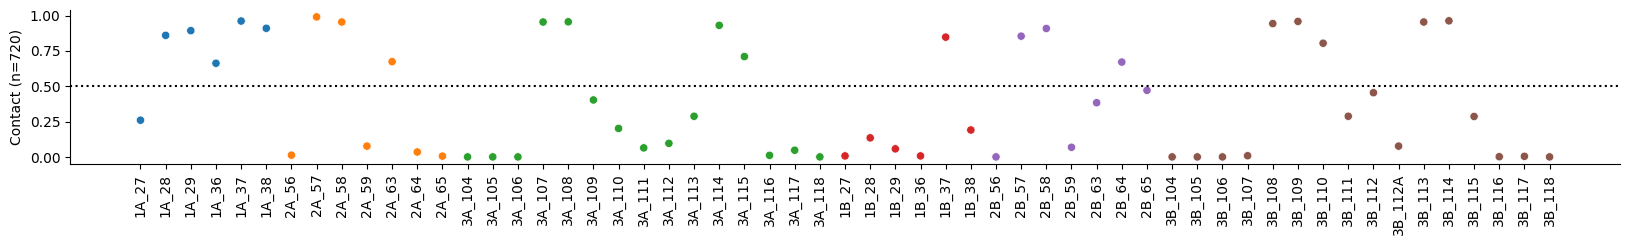

In [386]:
df = pd.read_csv('cdr_imgt_aligned_min_dist.csv', header=[0,1], index_col=0)
# Keep columns that have at least 5% non-NaN values
df = df.dropna(axis=1, thresh=int(0.05 * len(df)))

# convert distances to contacts
df = df.applymap(lambda x: 1 if x < 5 else 0)
print(df)
new_cols = []
for cdr_name, pos in df.columns:
    cdr_split = cdr_name.split('_')
    new_col = f'{cdr_split[0][-1]}{cdr_split[1][-1]}_{pos}'
    new_cols.append(new_col)

df.columns = new_cols
df_long = df.reset_index().melt(
    id_vars = 'index',
    var_name='position',
    value_name='contact'
)

df_long = df_long.rename(columns={'index':'tcr_id'})

# compute mean across all samples
df_mean = df_long.groupby('position')['contact'].mean().reset_index()

df_mean['cdr'] = [x.split('_')[0] for x in df_mean['position']]
cdr_order = ["1A", "2A", "3A", "1B", "2B", "3B"]
df_mean['cdr'] = pd.Categorical(df_mean['cdr'], categories=cdr_order, ordered=True)
df_mean = df_mean.sort_values(by=['cdr', 'position']).reset_index(drop=True)

fig, ax = plt.subplots(1,1,figsize=(20,2))
sns.scatterplot(df_mean, x='position', y='contact', hue='cdr', ax=ax, legend=False)
ax.tick_params(axis='x', rotation=90)
ax.set_xlabel('')
ax.set_ylabel(f'Contact (n={len(df)})')
ax.axhline(0.5, color='black', linestyle=':')
sns.despine()

/var/folders/2v/m8p5rbh538sgyrgvrcyb210h0000gn/T/ipykernel_56058/1554902465.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 1 if pd.notna(x) and x < 5
/var/folders/2v/m8p5rbh538sgyrgvrcyb210h0000gn/T/ipykernel_56058/1554902465.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 1 if pd.notna(x) and x < 5


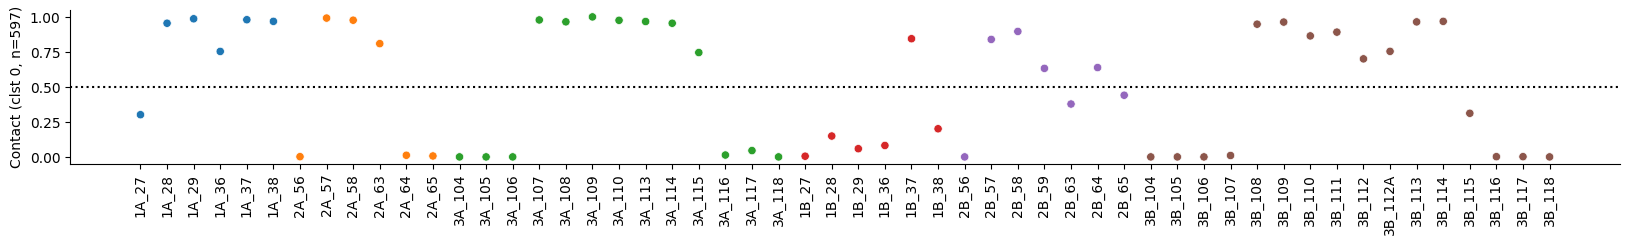

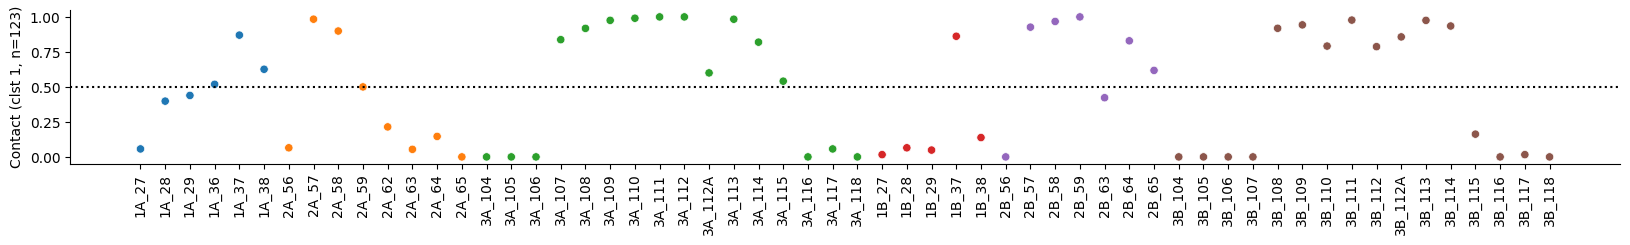

In [527]:
clusters = [0,1]

for cluster in clusters:
    df_anno = pd.read_csv('AF_models_high_conf.csv')
    df_anno['tcr_id'] = df_anno['id'].astype(str) + '.' + df_anno['batch'].astype(str)
    df_anno = df_anno[df_anno['cluster'] == cluster]
    tcr_ids = df_anno['tcr_id'].values
    
    df = pd.read_csv('cdr_imgt_aligned_min_dist.csv', header=[0,1], index_col=0)
    df = df.loc[df.index.isin(tcr_ids)]

    # Keep columns that have at least 5% non-NaN values
    df = df.dropna(axis=1, thresh=int(0.05 * len(df)))

    # convert distances to contacts
    df = df.applymap(lambda x: 1 if pd.notna(x) and x < 5
                           else (0 if pd.notna(x) else x))

    new_cols = []
    for cdr_name, pos in df.columns:
        cdr_split = cdr_name.split('_')
        new_col = f'{cdr_split[0][-1]}{cdr_split[1][-1]}_{pos}'
        new_cols.append(new_col)

    df.columns = new_cols
    df_long = df.reset_index().melt(
        id_vars = 'index',
        var_name='position',
        value_name='contact'
    )

    df_long = df_long.rename(columns={'index':'tcr_id'})
    tmp = df_long[df_long['position'] == '3A_110']

    # compute mean
    df_mean = df_long.groupby('position')['contact'].mean().reset_index()

    df_mean['cdr'] = [x.split('_')[0] for x in df_mean['position']]
    cdr_order = ["1A", "2A", "3A", "1B", "2B", "3B"]
    df_mean['cdr'] = pd.Categorical(df_mean['cdr'], categories=cdr_order, ordered=True)
    df_mean = df_mean.sort_values(by=['cdr', 'position']).reset_index(drop=True)

    fig, ax = plt.subplots(1,1,figsize=(20,2))
    sns.scatterplot(df_mean, x='position', y='contact', hue='cdr', ax=ax, legend=False)
    ax.tick_params(axis='x', rotation=90)
    ax.set_xlabel('')
    ax.set_ylabel(f'Contact (clst {cluster}, n={len(df)})')
    ax.axhline(0.5, color='black', linestyle=':')
    sns.despine()

# Integrate Alascan data

In [531]:
# find template clonotype
df_anno = pd.read_csv('AF_models_high_conf.csv')
df_anno['tcr_id'] = df_anno['id'].astype(str) + '.' + df_anno['batch'].astype(str)

df_anno = df_anno[(df_anno['TRAV'] == 'TRAV12-2') & (df_anno['TRAJ'] == 'TRAJ30') & (df_anno['TRBV'] == 'TRBV28')& (df_anno['TRBJ'] == 'TRBJ2-7')]
df_anno = df_anno[df_anno['cdr3_TRB'].str.len() == 13]
tcr_id = df_anno['tcr_id'].values[0]

# positions for experimentally tested TCR
df_aligned = pd.read_csv('cdr_imgt_aligned_min_dist.csv', header=[0,1], index_col=0)
df_aligned = df_aligned.loc[tcr_id].dropna()

aligned_positions = df_aligned.index

lst = []
df_cols = aligned_positions.to_frame(index=False, name=['CDR', 'position'])
for name, group in df_cols.groupby('CDR'):
    if (name == 'cdr3_TRA') | (name == 'cdr3_TRB'):
        group = group.iloc[1:-3] # remove positions that where not experimentally tested
        lst.append(group)
    else:
        lst.append(group)
        
df_cols = pd.concat(lst)
df_cols['position'] = df_cols['CDR'].str.split('_').str[0].str[-1] + df_cols['CDR'].str.split('_').str[1].str[-1] + '_' + df_cols['position'].astype(str)

# experimental data
df_exp = pd.read_csv('YF-AlaScan.csv', sep=';')
df_exp = df_exp[df_exp['Name'] != 'template']
df_exp['CDR'] = df_exp['Name'].str.split('_').str[0]

# add position assignement (coorect order)
df_exp['position'] = df_cols['position'].values
df_exp['Results_mod'] = (100 - df_exp['Results']) / 100
df_exp.to_csv('YF-AlaScan_anno_aligned_pos.csv', index=False)

/var/folders/2v/m8p5rbh538sgyrgvrcyb210h0000gn/T/ipykernel_56058/1681508257.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 1 if pd.notna(x) and x < 5
/var/folders/2v/m8p5rbh538sgyrgvrcyb210h0000gn/T/ipykernel_56058/1681508257.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 1 if pd.notna(x) and x < 5


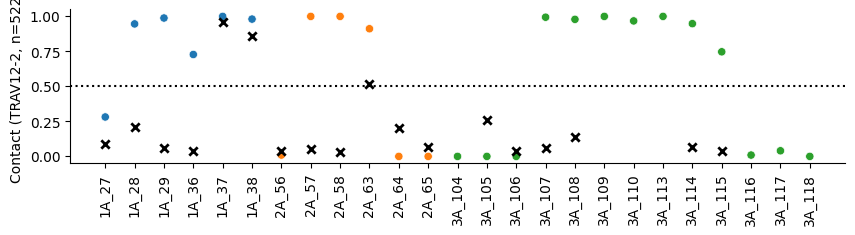

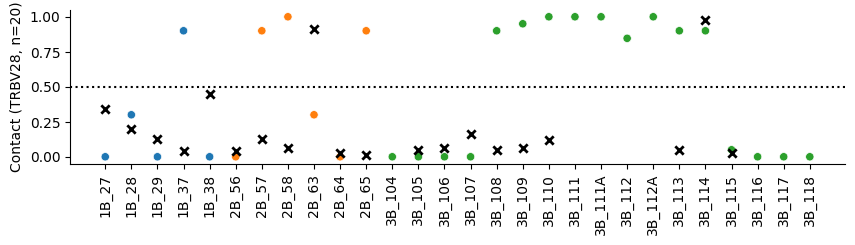

In [530]:
# experimental data
df_exp = pd.read_csv('YF-AlaScan_anno_aligned_pos.csv')[['position', 'Results_mod']]

clusters = ['TRAV12-2','TRBV28']

for cluster in clusters:
    df_anno = pd.read_csv('AF_models_high_conf.csv')
    df_anno['tcr_id'] = df_anno['id'].astype(str) + '.' + df_anno['batch'].astype(str)

    if cluster == 'TRAV12-2':
        df_anno = df_anno[df_anno['TRAV'] == cluster]
    else:
        df_anno = df_anno[df_anno['TRBV'] == cluster]
    tcr_ids = df_anno['tcr_id'].values
    
    df = pd.read_csv('cdr_imgt_aligned_min_dist.csv', header=[0,1], index_col=0)
    df = df.loc[df.index.isin(tcr_ids)]
    
    # Keep columns that have at least 5% non-NaN values
    df = df.dropna(axis=1, thresh=int(0.05 * len(df)))

    # convert distances to contacts
    df = df.applymap(lambda x: 1 if pd.notna(x) and x < 5
                           else (0 if pd.notna(x) else x))

    new_cols = []
    for cdr_name, pos in df.columns:
        cdr_split = cdr_name.split('_')
        new_col = f'{cdr_split[0][-1]}{cdr_split[1][-1]}_{pos}'
        new_cols.append(new_col)

    df.columns = new_cols
    df_long = df.reset_index().melt(
        id_vars = 'index',
        var_name='position',
        value_name='contact'
    )

    df_long = df_long.rename(columns={'index':'tcr_id'})

    # compute mean
    df_mean = df_long.groupby('position')['contact'].mean().reset_index()
    df_mean['cdr'] = [x.split('_')[0] for x in df_mean['position']]
    if cluster == 'TRAV12-2':
        df_mean = df_mean[df_mean['position'].str.contains('A_')]
    else:
        df_mean = df_mean[df_mean['position'].str.contains('B_')]
    
    # add experimental data
    df_mean = pd.merge(df_mean, df_exp, on='position', how='left')

    fig, ax = plt.subplots(1,1,figsize=(10,2))
    sns.scatterplot(df_mean, x='position', y='contact', hue='cdr', ax=ax, legend=False)
    sns.scatterplot(df_mean, x='position', y='Results_mod', ax=ax, legend=False, color='black', marker='x', linewidth=2)
    ax.tick_params(axis='x', rotation=90)
    ax.set_xlabel('')
    ax.set_ylabel(f'Contact ({cluster}, n={len(df)})')
    ax.axhline(0.5, color='black', linestyle=':')
    sns.despine()


# In silico AlaScan

In [12]:
topdir = '../260202_YF-modes/data_julien'
batches = {'LAU5013': 'LAU5013/YF_LAU5013_sc_WT', 
           'Public_Data':'Public_Data/YF_public_pairedData_20251010'}

genes = ['TRAV12-2', 'TRBV28']

lst = []
for gene in genes:
    df = pd.read_csv('AF_models_high_conf.csv')
    df = df[df[gene[:4]] == gene]

    # Select 10 TCRs with diversity in TRAJ / TRBJ
    unique_j = df[f'{gene[:3]}J'].dropna().unique()
    n_select = min(10, len(unique_j))
    chosen_j = pd.Series(unique_j).sample(n_select, random_state=None)

    df_diverse = (
    df[df[f'{gene[:3]}J'].isin(chosen_j)]
      .groupby(f'{gene[:3]}J', group_keys=False)
      .apply(lambda x: x.sample(1))
)

    remaining_needed = 10 - len(df_diverse)

    if remaining_needed > 0:
        remaining_pool = df.drop(df_diverse.index)
        df_fill = remaining_pool.sample(remaining_needed)
        df_selected = pd.concat([df_diverse, df_fill])
    else:
        df_selected = df_diverse
    
    for idx, row in df_selected.iterrows():
        tcr_id = row['id']
        batch_short = row['batch']

        pdb_file = f'{topdir}/{batches[batch_short]}/model_pdb_align_exp/{tcr_id}.pdb'
        chain_map={"TRA":"B","TRB":"C"}

        # get residue ids
        cdr_dict = {cdr: str(row[cdr]).upper() for cdr in ["cdr1_TRA","cdr2_TRA","cdr3_TRA","cdr1_TRB","cdr2_TRB","cdr3_TRB"]}
        cdr_resids = extract_cdr_resids(pdb_file, cdr_dict, chain_map)

        # for CDR3 drop first and last three residues
        cdr_resids["cdr3_TRA"] = cdr_resids["cdr3_TRA"][1:-3]
        cdr_resids["cdr3_TRB"] = cdr_resids["cdr3_TRB"][1:-3]

        if gene == 'TRAV12-2':
            keys_to_remove = ["cdr1_TRB","cdr2_TRB","cdr3_TRB"]
        else:
            keys_to_remove = ["cdr1_TRA","cdr2_TRA","cdr3_TRA"]

        for key in keys_to_remove:
            cdr_resids.pop(key, None)
        
        resids_to_mutate = np.concatenate(list(cdr_resids.values())) -1

        if gene == 'TRAV12-2':
            for r in resids_to_mutate:
                row_copy = row.to_dict()

                seq = row['TRA_full']
                seq_mod = seq[:r] + 'A' + seq[r+1:]
                row_copy['TRA_mod'] = seq_mod
                row_copy['TRB_mod'] = row['TRB_full'] 
                lst.append(row_copy)
        else:
            for r in resids_to_mutate:
                row_copy = row.to_dict()

                seq = row['TRB_full']
                seq_mod = seq[:r] + 'A' + seq[r+1:]
                row_copy['TRA_mod'] = row_copy['TRA_full'] 
                row_copy['TRB_mod'] = seq_mod
                lst.append(row_copy)

df = pd.DataFrame(lst)
df = df.drop(columns=['TRA_full', 'TRB_full'])
df['id'] = df['id'] + '.' + df['batch'] + '.' + df.index.astype(str)
df = df.rename(columns={'TRA_mod':'TRA_full', 'TRB_mod':'TRB_full'})
df = df[['id', 'TRAV', 'TRAJ', 'TRBV', 'TRBJ', 'cdr3_TRA', 'cdr3_TRB', 'TRA_full', 'TRB_full']]
df['peptide'] = 'LLWNGPMAV'
df['MHC'] = 'HLA_A0201'
df['species'] = 'HomoSapiens'

df.to_csv('AlaScan_in_silico.csv', index=False)
df       

/var/folders/2v/m8p5rbh538sgyrgvrcyb210h0000gn/T/ipykernel_2535/3874077731.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(1))
/var/folders/2v/m8p5rbh538sgyrgvrcyb210h0000gn/T/ipykernel_2535/3874077731.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(1))


id      TRAV    TRAJ     TRBV     TRBJ  \
0      tcr0093.Public_Data.0  TRAV12-2  TRAJ16  TRBV6-4  TRBJ2-7   
1      tcr0093.Public_Data.1  TRAV12-2  TRAJ16  TRBV6-4  TRBJ2-7   
2      tcr0093.Public_Data.2  TRAV12-2  TRAJ16  TRBV6-4  TRBJ2-7   
3      tcr0093.Public_Data.3  TRAV12-2  TRAJ16  TRBV6-4  TRBJ2-7   
4      tcr0093.Public_Data.4  TRAV12-2  TRAJ16  TRBV6-4  TRBJ2-7   
..                       ...       ...     ...      ...      ...   
394  tcr0215.Public_Data.394  TRAV12-2  TRAJ31   TRBV28  TRBJ2-2   
395  tcr0215.Public_Data.395  TRAV12-2  TRAJ31   TRBV28  TRBJ2-2   
396  tcr0215.Public_Data.396  TRAV12-2  TRAJ31   TRBV28  TRBJ2-2   
397  tcr0215.Public_Data.397  TRAV12-2  TRAJ31   TRBV28  TRBJ2-2   
398  tcr0215.Public_Data.398  TRAV12-2  TRAJ31   TRBV28  TRBJ2-2   

         cdr3_TRA        cdr3_TRB  \
0    CAVNADGQKLLF   CAVGAGATYEQYF   
1    CAVNADGQKLLF   CAVGAGATYEQYF   
2    CAVNADGQKLLF   CAVGAGATYEQYF   
3    CAVNADGQKLLF   CAVGAGATYEQYF   
4    CAVNADGQKLLF   CAVGAGATYEQYF   
..            ...             ...   
394   CAVDANARLMF  CASSYFKGAGELFF   
395   CAVDANARLMF  CASSYFKGAGELFF   
396   CAVDANARLMF  CASSYFKGAGELFF   
397   CAVDANARLMF  CASSYFKGAGELFF   
398   CAVDANARLMF  CASSYFKGAGELFF   

                                              TRA_full  \
0    QKEVEQNSGPLSVPEGAIASLNCTYSARGSQSFFWYRQYSGKSPEL...   
1    QKEVEQNSGPLSVPEGAIASLNCTYSDAGSQSFFWYRQYSGKSPEL...   
2    QKEVEQNSGPLSVPEGAIASLNCTYSDRASQSFFWYRQYSGKSPEL...   
3    QKEVEQNSGPLSVPEGAIASLNCTYSDRGAQSFFWYRQYSGKSPEL...   
4    QKEVEQNSGPLSVPEGAIASLNCTYSDRGSASFFWYRQYSGKSPEL...   
..                                                 ...   
394  QKEVEQNSGPLSVPEGAIASLNCTYSDRGSQSFFWYRQYSGKSPEL...   
395  QKEVEQNSGPLSVPEGAIASLNCTYSDRGSQSFFWYRQYSGKSPEL...   
396  QKEVEQNSGPLSVPEGAIASLNCTYSDRGSQSFFWYRQYSGKSPEL...   
397  QKEVEQNSGPLSVPEGAIASLNCTYSDRGSQSFFWYRQYSGKSPEL...   
398  QKEVEQNSGPLSVPEGAIASLNCTYSDRGSQSFFWYRQYSGKSPEL...   

                                              TRB_full    peptide        MHC  \
0    IAGITQAPTSQILAAGRRMTLRCTQDMRHNAMYWYRQDLGLGLRLI...  LLWNGPMAV  HLA_A0201   
1    IAGITQAPTSQILAAGRRMTLRCTQDMRHNAMYWYRQDLGLGLRLI...  LLWNGPMAV  HLA_A0201   
2    IAGITQAPTSQILAAGRRMTLRCTQDMRHNAMYWYRQDLGLGLRLI...  LLWNGPMAV  HLA_A0201   
3    IAGITQAPTSQILAAGRRMTLRCTQDMRHNAMYWYRQDLGLGLRLI...  LLWNGPMAV  HLA_A0201   
4    IAGITQAPTSQILAAGRRMTLRCTQDMRHNAMYWYRQDLGLGLRLI...  LLWNGPMAV  HLA_A0201   
..                                                 ...        ...        ...   
394  DVKVTQSSRYLVKRTGEKVFLECVQDMDHENMFWYRQDPGLGLRLI...  LLWNGPMAV  HLA_A0201   
395  DVKVTQSSRYLVKRTGEKVFLECVQDMDHENMFWYRQDPGLGLRLI...  LLWNGPMAV  HLA_A0201   
396  DVKVTQSSRYLVKRTGEKVFLECVQDMDHENMFWYRQDPGLGLRLI...  LLWNGPMAV  HLA_A0201   
397  DVKVTQSSRYLVKRTGEKVFLECVQDMDHENMFWYRQDPGLGLRLI...  LLWNGPMAV  HLA_A0201   
398  DVKVTQSSRYLVKRTGEKVFLECVQDMDHENMFWYRQDPGLGLRLI...  LLWNGPMAV  HLA_A0201   

         species  
0    HomoSapiens  
1    HomoSapiens  
2    HomoSapiens  
3    HomoSapiens  
4    HomoSapiens  
..           ...  
394  HomoSapiens  
395  HomoSapiens  
396  HomoSapiens  
397  HomoSapiens  
398  HomoSapiens  

[399 rows x 12 columns]

# Integrate X-scan data

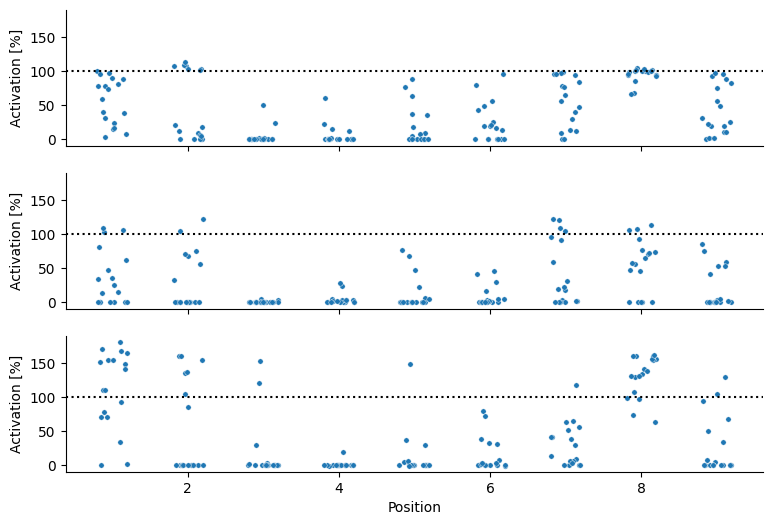

In [45]:
fig, axes = plt.subplots(3,1, figsize=(9,6), sharex=True, sharey=True)

file = 'TableS10_X-scan_oriDATA.xlsx'

for i in range(3):
    ax = axes[i]
    df = pd.read_excel(file, sheet_name=i)
    df['Aa'] = df['Aa'].str[0]
    df['Position'] = df['Position'].str[-1].astype(int)
    
    
    jitter = np.random.uniform(-0.2, 0.2, size=len(df)) 
    sns.scatterplot(x=df['Position'] + jitter, y=df['ActivationScore'], ax=ax, s=15)
    ax.axhline(100, color='black', linestyle=':')
    ax.set_ylabel('Activation [%]')

sns.despine()

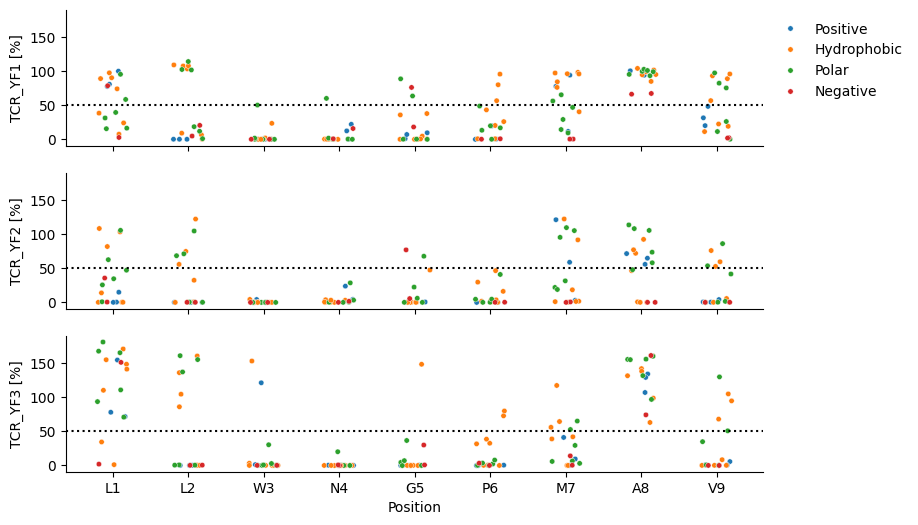

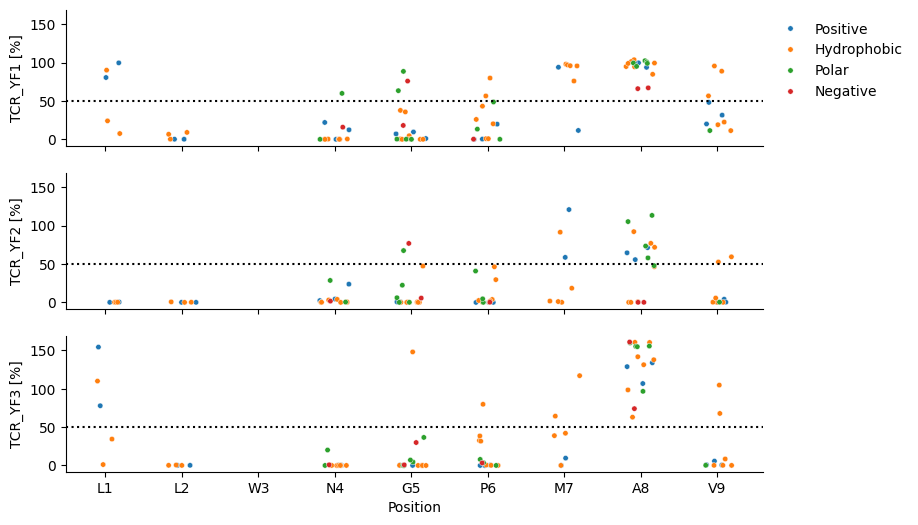

In [138]:
# only consider mutant whe AA category is changing
# Define amino acid groups
aa_type_map = {
    'A': 'Hydrophobic', 'V': 'Hydrophobic', 'I': 'Hydrophobic', 'L': 'Hydrophobic',
    'M': 'Hydrophobic', 'F': 'Hydrophobic', 'W': 'Hydrophobic', 'Y': 'Hydrophobic',
    
    'D': 'Negative', 'E': 'Negative',
    'K': 'Positive', 'R': 'Positive', 'H': 'Positive',
    
    'S': 'Polar', 'T': 'Polar', 'N': 'Polar', 'Q': 'Polar', 'C': 'Polar', 'G': 'Polar', 'P': 'Polar',

}

# Define amino acid volumes
aa_volume = {
    'G': 60,  'A': 88,  'S': 89,  'C': 108,
    'P': 112, 'T': 116, 'D': 111, 'N': 114,
    'V': 140, 'E': 138, 'Q': 143, 'H': 153,
    'M': 162, 'I': 166, 'L': 166, 'K': 168,
    'R': 173, 'F': 189, 'Y': 193, 'W': 227
}

file = 'TableS10_X-scan_oriDATA.xlsx'

df_epitope = pd.DataFrame()
sequence = 'LLWNGPMAV'
df_epitope['Aa_WT'] = list(sequence)
df_epitope['Position'] = np.arange(len(sequence)) + 1

lst = []
for i in range(3):
    df = pd.read_excel(file, sheet_name=i)
    df['Aa'] = df['Aa'].str[0]
    df['Position'] = df['Position'].str[-1].astype(int)
    
    # annotate WT sequence
    df = pd.merge(df, df_epitope, on='Position')
    
    # annotate aa type
    df['Aa_type'] = df['Aa'].map(aa_type_map)
    df['Aa_WT_type'] = df['Aa_WT'].map(aa_type_map)
    
    # add volume annotation
    df['Vol_mut'] = df['Aa'].map(aa_volume)
    df['Vol_WT'] = df['Aa_WT'].map(aa_volume)
    df['TCR'] = f'TCR_YF{i+1}'

    lst.append(df)

df = pd.concat(lst)
df.to_pickle('activation_scores.pkl')

fig, axes = plt.subplots(3,1, figsize=(9,6), sharex=True, sharey=True)
for i in range(3):
    ax = axes[i]
    tmp = df[df['TCR'] == f'TCR_YF{i+1}']

    jitter = np.random.uniform(-0.2, 0.2, size=len(tmp)) 
    sns.scatterplot(x=tmp['Position'] + jitter, y=tmp['ActivationScore'], ax=ax, s=15, hue=tmp['Aa_type'])
    ax.legend('', '', frameon=False)
    ax.axhline(50, color='black', linestyle=':')
    #ax.axhline(100, color='black', linestyle=':')
    ax.set_ylabel(f'TCR_YF{i+1} [%]')

axes[0].legend(bbox_to_anchor=(1,1), frameon=False, title='')
new_labels = [f'{sequence[i]}{i+1}' for i in range(9)]
axes[2].set_xticks(range(1, len(new_labels)+1))
axes[2].set_xticklabels(new_labels)

sns.despine()

# only consider mutations where size of amino acid is increased
fig, axes = plt.subplots(3,1, figsize=(9,6), sharex=True, sharey=True)
for i in range(3):
    ax = axes[i]
    tmp = df[df['TCR'] == f'TCR_YF{i+1}']
    tmp = tmp[tmp['Vol_mut'] > tmp['Vol_WT']]
    
    jitter = np.random.uniform(-0.2, 0.2, size=len(tmp)) 
    sns.scatterplot(x=tmp['Position'] + jitter, y=tmp['ActivationScore'], ax=ax, s=15, hue=tmp['Aa_type'])
    ax.legend('', '', frameon=False)
    ax.axhline(50, color='black', linestyle=':')
    #ax.axhline(100, color='black', linestyle=':')
    ax.set_ylabel(f'TCR_YF{i+1} [%]')

axes[0].legend(bbox_to_anchor=(1,1), frameon=False, title='')
new_labels = [f'{sequence[i]}{i+1}' for i in range(9)]
axes[2].set_xticks(range(1, len(new_labels)+1))
axes[2].set_xticklabels(new_labels)

sns.despine()

In [55]:
# predict experimentally tested models

dico = [
    {'id': 'TCR_YF1', 'TRAV':'TRAV12-2', 'TRAJ':'TRAJ30', 'cdr3_TRA':'CAVGDDKIIF', 'TRBV':'TRBV28', 'TRBJ':'TRBJ2-7', 'cdr3_TRB':'CASTPQTAYEQYF'},
    {'id': 'TCR_YF2', 'TRAV':'TRAV12-2', 'TRAJ':'TRAJ30', 'cdr3_TRA':'CAVNPDKIIF', 'TRBV':'TRBV4-2', 'TRBJ':'TRBJ1-4', 'cdr3_TRB':'CASSQEDRGPEKLFF'},
    {'id': 'TCR_YF3', 'TRAV':'TRAV12-2', 'TRAJ':'TRAJ30', 'cdr3_TRA':'CAAGDDKIIF', 'TRBV':'TRBV29-1', 'TRBJ':'TRBJ2-1', 'cdr3_TRB':'CSVATSGGSNEQFF'}
]

df = pd.DataFrame(dico)
df['peptide'] = 'LLWNGPMAV'
df['MHC'] = 'HLA_A0201'
df['species'] = 'HomoSapiens'

df.to_csv('Xscan_models.csv', index=False)
df

id      TRAV    TRAJ    cdr3_TRA      TRBV     TRBJ         cdr3_TRB  \
0  TCR_YF1  TRAV12-2  TRAJ30  CAVGDDKIIF    TRBV28  TRBJ2-7    CASTPQTAYEQYF   
1  TCR_YF2  TRAV12-2  TRAJ30  CAVNPDKIIF   TRBV4-2  TRBJ1-4  CASSQEDRGPEKLFF   
2  TCR_YF3  TRAV12-2  TRAJ30  CAAGDDKIIF  TRBV29-1  TRBJ2-1   CSVATSGGSNEQFF   

     peptide        MHC      species  
0  LLWNGPMAV  HLA_A0201  HomoSapiens  
1  LLWNGPMAV  HLA_A0201  HomoSapiens  
2  LLWNGPMAV  HLA_A0201  HomoSapiens

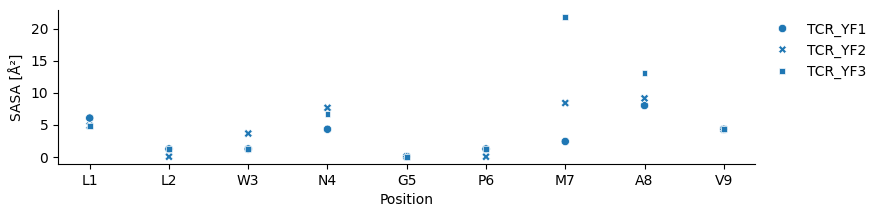

In [99]:
topdir = 'Xscan_models/AF3_outputs'

parser = MMCIFParser(QUIET=True)
results = {'Position':[],
           'SASA':[],
           'TCR':[]}

for i in range(3):
    file = f'{topdir}/tcr_yf{i+1}/tcr_yf{i+1}_model.cif'
    structure = parser.get_structure('structure', file)
    
    sr = ShrakeRupley()
    sr.compute(structure, level="R")  # R = per residue
    
    for model in structure:
        for chain in model:
            if chain.id == "PEPTIDE":   # change if needed
                for residue in chain:
                    results['Position'].append(residue.id[1])
                    results['SASA'].append(residue.sasa)
                    results['TCR'].append(f'TCR_YF{i+1}')

df = pd.DataFrame(results)

fig, ax = plt.subplots(1,1, figsize=(9,2), sharex=True, sharey=True)

sns.scatterplot(df, x='Position', y='SASA', ax=ax, style='TCR')

ax.legend(bbox_to_anchor=(1,1), frameon=False, title='')
sequence = 'LLWNGPMAV'
new_labels = [f'{sequence[i]}{i+1}' for i in range(9)]
ax.set_xticks(range(1, len(new_labels)+1))
ax.set_xticklabels(new_labels)
ax.set_ylabel('SASA [Å²]')


sns.despine()

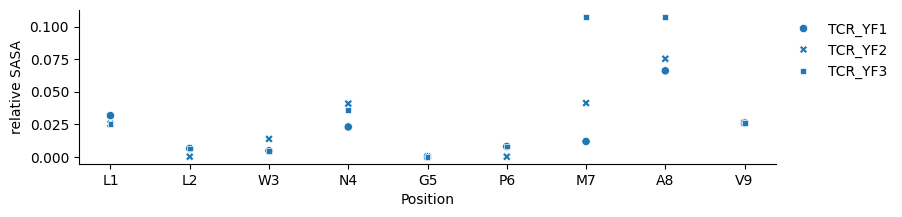

In [132]:
# normalize SASA to residue size
max_sasa = {
    'A': 121, 'R': 265, 'N': 187, 'D': 187,
    'C': 148, 'Q': 214, 'E': 214, 'G': 97,
    'H': 216, 'I': 195, 'L': 191, 'K': 230,
    'M': 203, 'F': 228, 'P': 154, 'S': 143,
    'T': 163, 'W': 264, 'Y': 255, 'V': 165
}

sequence = 'LLWNGPMAV'

topdir = 'Xscan_models/AF3_outputs'

parser = MMCIFParser(QUIET=True)
results = {'Position':[],
           'SASA':[],
           'rSASA':[],
           'TCR':[]}

for i in range(3):
    file = f'{topdir}/tcr_yf{i+1}/tcr_yf{i+1}_model.cif'
    structure = parser.get_structure('structure', file)
    
    sr = ShrakeRupley()
    sr.compute(structure, level="R")  # R = per residue
    
    for model in structure:
        for chain in model:
            if chain.id == "PEPTIDE":   # change if needed
                for residue in chain:
                    results['Position'].append(residue.id[1])
                    results['SASA'].append(residue.sasa)
                    wt_aa = sequence[residue.id[1] - 1]
                    results['rSASA'].append(residue.sasa / max_sasa[wt_aa])
                    results['TCR'].append(f'TCR_YF{i+1}')

df = pd.DataFrame(results)
df.to_pickle('relative_sasa.pkl')
fig, ax = plt.subplots(1,1, figsize=(9,2), sharex=True, sharey=True)

sns.scatterplot(df, x='Position', y='rSASA', ax=ax, style='TCR')

ax.legend(bbox_to_anchor=(1,1), frameon=False, title='')
new_labels = [f'{sequence[i]}{i+1}' for i in range(9)]
ax.set_xticks(range(1, len(new_labels)+1))
ax.set_xticklabels(new_labels)
ax.set_ylabel('relative SASA')


sns.despine()

   Position  Contacts TCR  Contacts MHC  Contacts all      TCR
0         1      0.875000      0.000000      0.000000  TCR_YF1
1         2      0.875000      0.000000      0.000000  TCR_YF1
2         3      0.714286      0.214286      0.214286  TCR_YF1
3         4      0.125000      0.625000      0.125000  TCR_YF1
4         5      0.250000      0.750000      0.250000  TCR_YF1


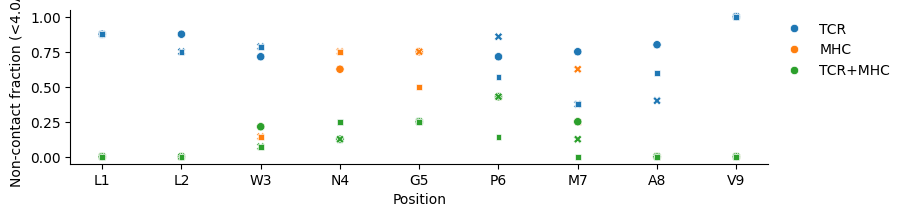

In [173]:
topdir = 'Xscan_models/AF3_outputs'
parser = MMCIFParser(QUIET=True)

results = {'Position': [],
           'Contacts TCR': [],
           'Contacts MHC': [],
           'Contacts all': [],
           'TCR': []}

cutoff = 4.0  # Å heavy-atom contact cutoff

for i in range(3):
    file = f'{topdir}/tcr_yf{i+1}/tcr_yf{i+1}_model.cif'
    structure = parser.get_structure('structure', file)

    model = next(structure.get_models())

    peptide_chain = model['PEPTIDE']
    tcra_chain = model['TCRA']
    tcrb_chain = model['TCRB']
    mhc_chain = model['MHC']

    # Collect heavy atoms from TCRA + TCRB
    tcr_atoms = [
        atom for chain in [tcra_chain, tcrb_chain]
        for atom in chain.get_atoms()
        if atom.element != 'H'
    ]

    mhc_atoms = [
        atom for chain in [mhc_chain]
        for atom in chain.get_atoms()
        if atom.element != 'H'
    ]

    all_atoms = [
        atom for chain in [tcra_chain, tcrb_chain, mhc_chain]
        for atom in chain.get_atoms()
        if atom.element != 'H'
    ]

    # Build fast spatial search tree
    ns_dico = {'TCR' : NeighborSearch(tcr_atoms),
          'MHC' : NeighborSearch(mhc_atoms),
          'all' : NeighborSearch(all_atoms)}

    for residue in peptide_chain:

        # Heavy atoms in peptide residue
        pep_atoms = [atom for atom in residue if atom.element != 'H']

        for name, ns in ns_dico.items():
            contacting_atoms = set()

            for atom in pep_atoms:
                neighbors = ns.search(atom.coord, cutoff)
                if neighbors:
                    contacting_atoms.add(atom)

            contact_count = 1 - (len(contacting_atoms)/len(pep_atoms)) # percentage of residue atoms being in NOT contact with TCR
            results[f'Contacts {name}'].append(contact_count)

        results['Position'].append(residue.id[1])
        results['TCR'].append(f'TCR_YF{i+1}')

df = pd.DataFrame(results)
print(df.head())
df.to_pickle('non_contact_fraction.pkl')

fig, ax = plt.subplots(1,1, figsize=(9,2))

sns.scatterplot(data=df, x='Position', y='Contacts TCR', ax=ax, style='TCR')
sns.scatterplot(data=df, x='Position', y='Contacts MHC', ax=ax, style='TCR')
sns.scatterplot(data=df, x='Position', y='Contacts all', ax=ax, style='TCR')

ax.set_ylabel(f'Non-contact fraction (<{cutoff}Å)')

sequence = 'LLWNGPMAV'
new_labels = [f'{sequence[i]}{i+1}' for i in range(9)]
ax.set_xticks(range(1, len(new_labels)+1))
ax.set_xticklabels(new_labels)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=[handles[0], handles[3], handles[6]], labels=['TCR', 'MHC', 'TCR+MHC'], bbox_to_anchor=(1,1), frameon=False, title='', loc='upper left')

sns.despine()


# Correlate average activity across mutations with relative SASA / non contact fraction

    Position      TCR  ActivationScore     rSASA  Contacts TCR
0          1  TCR_YF1         0.431737  0.293562      0.875000
1          1  TCR_YF2         0.269992  0.234850      0.875000
2          1  TCR_YF3         0.852233  0.234850      0.875000
3          2  TCR_YF1         0.347462  0.058712      0.875000
4          2  TCR_YF2         0.225482  0.000000      0.750000
5          2  TCR_YF3         0.400501  0.058712      0.750000
6          3  TCR_YF1         0.032656  0.042478      0.714286
7          3  TCR_YF2         0.003398  0.127433      0.785714
8          3  TCR_YF3         0.132844  0.042478      0.785714
9          4  TCR_YF1         0.048344  0.212826      0.125000
10         4  TCR_YF2         0.031908  0.379207      0.125000
11         4  TCR_YF3         0.009033  0.332763      0.250000
12         5  TCR_YF1         0.145853  0.000000      0.250000
13         5  TCR_YF2         0.096952  0.000000      0.250000
14         5  TCR_YF3         0.096258  0.000000      0

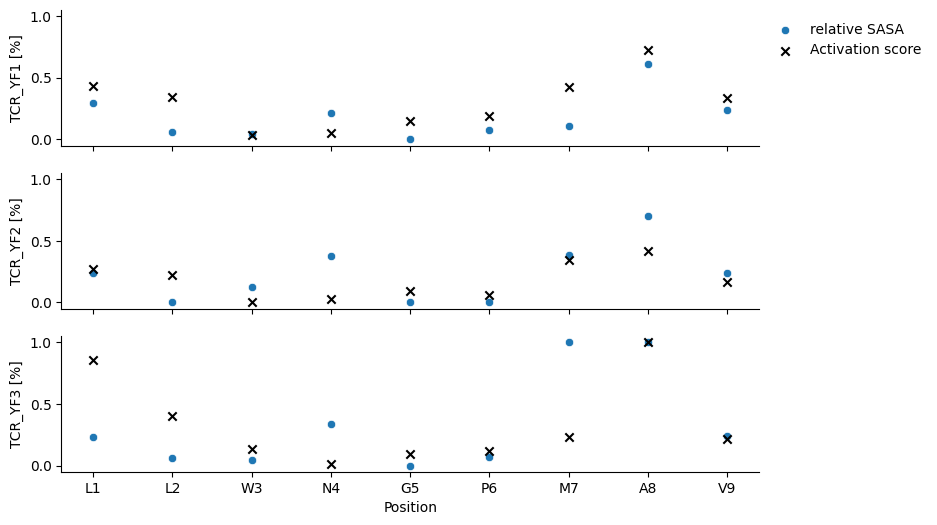

In [179]:
df_activation = pd.read_pickle('activation_scores.pkl')[['Position', 'TCR', 'ActivationScore']]
df_activation['ActivationScore'] = df_activation['ActivationScore']/100
df_activation = (df_activation
        .groupby(['Position', 'TCR'], as_index=False)['ActivationScore']
        .mean())
df_activation['ActivationScore'] = df_activation['ActivationScore'] / df_activation['ActivationScore'].max() # scale (maximum to one)

df_sasa = pd.read_pickle('relative_sasa.pkl')[['Position', 'TCR', 'rSASA']]
df_sasa['rSASA'] = df_sasa['rSASA'] / df_sasa['rSASA'].max() # scale (maximum to one)

df_contacts = pd.read_pickle('non_contact_fraction.pkl')[['Position', 'TCR', 'Contacts TCR']]
df_contacts['Contacts TCR'] = df_contacts['Contacts TCR'] / df_contacts['Contacts TCR'].max() # scale (maximum to one)

df = pd.merge(df_activation, df_sasa, on=['Position', 'TCR'])
df = pd.merge(df, df_contacts, on=['Position', 'TCR'])
print(df)

fig, axes = plt.subplots(3,1, figsize=(9,6), sharex=True, sharey=True)

for i in range(3):
        ax = axes[i]
        tmp = df[df['TCR'] == f'TCR_YF{i+1}']
        #sns.scatterplot(data=tmp, x='Position', y='Contacts TCR', ax=ax, label='non TCR Contacts', )
        sns.scatterplot(data=tmp, x='Position', y='rSASA', ax=ax, label='relative SASA')
        sns.scatterplot(data=tmp, x='Position', y='ActivationScore', ax=ax, label='Activation score', marker='x', color='black', linewidth=1.5)
        ax.legend([], [], frameon=False)
        ax.set_ylabel(f'TCR_YF{i+1} [%]')



axes[0].legend(bbox_to_anchor=(1,1), frameon=False, title='', loc='upper left')
new_labels = [f'{sequence[i]}{i+1}' for i in range(9)]
axes[2].set_xticks(range(1, len(new_labels)+1))
axes[2].set_xticklabels(new_labels)

sns.despine()
